<a href="https://colab.research.google.com/github/yqwang1/Computational_Neuro/blob/main/Randomization_test_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download the class data and library

!git clone https://github.com/kdharris101/NeuralCodingClass.git

Cloning into 'NeuralCodingClass'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 59 (delta 0), reused 3 (delta 0), pack-reused 56 (from 2)
Receiving objects: 100% (59/59), 125.56 MiB | 13.39 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (52/52), done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

import NeuralCodingClass.neurocode as nc

In [ ]:
# load the data
data_dir = 'NeuralCodingClass/data/ibl'

# each IBL experiment has an "experiment id". we will look at one experiment:
eid='e0928e11-2b86-4387-a203-80c77fab5d52'

# for now we only need behavior information, about the trials of the task:
trials = nc.load_object(os.path.join(data_dir, eid, 'trials'))



In [ ]:
# the trials object is a "Bunch", a simple datastructure which contains many
# arrays, all with the same number of rows.
# each row of the array corresponds to one trial of the IBL task
# anything ending in "_times" is a time in

# let's see what's in it:

for k in trials.keys():
  print(f'trials.{k:<20}: size {trials[k].shape}\t dtype {trials[k].dtype}')



trials.probabilityLeft     : size (474,)	 dtype float64
trials.rewardVolume        : size (474,)	 dtype float64
trials.stim_side           : size (474,)	 dtype int64
trials.response_times      : size (474,)	 dtype float64
trials.stimOff_times       : size (474,)	 dtype float64
trials.intervals           : size (474, 2)	 dtype float64
trials.choice              : size (474,)	 dtype float64
trials.feedbackType        : size (474,)	 dtype float64
trials.contrastRight       : size (474,)	 dtype float64
trials.goCueTrigger_times  : size (474,)	 dtype float64
trials.feedback_times      : size (474,)	 dtype float64
trials.stimOn_times        : size (474,)	 dtype float64
trials.goCue_times         : size (474,)	 dtype float64
trials.contrastLeft        : size (474,)	 dtype float64
trials.firstMovement_times : size (474,)	 dtype float64


In [ ]:
# get the number of trials
n_trials = len(trials)

# compute reaction times for each trial as the time of movement - stim on time.
trials.delay = trials.firstMovement_times - trials.stimOn_times

The IBL task has stimuli appearing on the left or right, with a probability that switches in blocks.  The first block has 50% probability of left stimuli.  Subsequent blocks have 20% or 80% probability of left, and the block switches randomly.

To do our statistical tests, we are going to compare actual data to re-randomized block or contrast sequences.

Now we define two functions, to simulate the block sequence, and to simulate the contrast sequence conditional on the block sequence

In [ ]:
def generate_probabilities(n_trials):
    '''
    generate_probabilities(n_trials)

    generates a sequence of stimulus side probabilities (i.e. the block sequence) using the rules
    of the IBL task.

    first the unbiased block: 90 trials at 50%

    then alternating blocks of 20% and 80%, starting on a random side.

    the length of each block follows an exponential distribution  of scale 60, truncated between 20 and 100

    inputs
    ------
    n_trials: int, number of trials to generate

    returns
    -------
    probabilityLeft: 1d array of length n_trials containing 0.5, 0.2, 0.8

    '''

    probabilityLeft = np.zeros(n_trials)

    probabilityLeft[:90] = 0.5
    t = 90

    # choose first probability as 0.2 or 0.8
    prob = 0.2 + (np.random.rand()>.5)*.6

    # loop over blocks
    while t<n_trials:

        # generate block length from an exponential distribution, scale 60, truncated between 20 and 100
        l = 0
        while (l<20 or l>100):
            l = int(np.random.exponential(60))

        # set the next block in probabilityLeft
        t_old = t
        t = np.minimum(t+l, n_trials)
        probabilityLeft[t_old:t] = prob

        # flip the probability for the next block
        prob = 1-prob

    return probabilityLeft

In [ ]:
def generate_contrasts(probabilityLeft):
    '''
    generate_contrasts(probabilityLeft)

    generates a sequence of contrasts using the rules of the IBL task, from the block sequence
    encoded in the variable probabilityLeft.

    on each trial, it chooses a stimulus side, which is +1 (i.e. left) with prbability from the entry
    in probabilityLeft.

    it then chooses a contrast from this side, which can be 1, 0.25, 0.125, 0.0625, or 0
    with probabilities 2/9, 2/9, 2/9, 2/9 and 1/9

    inputs
    ------
    probabilityLeft: 1d numpy array containing probability of a left stimulus on each trial

    returns
    -------
    contrastLeft: contrast shown on the left screen on each trial
    contrastRight: contrast shown on the right screen on each trial
    stim_side: which side has the stimulus. This is needed to disambiguate 0-contrast trials

    '''
    n_trials = len(probabilityLeft)
    stim_side = 2*(np.random.rand(n_trials)<=probabilityLeft)-1

    contrasts = np.random.choice([0., 0.0625, 0.0625, 0.125, 0.125, 0.25, 0.25, 1., 1.], n_trials)
    contrastLeft = contrasts*(stim_side==1)
    contrastRight = contrasts*(stim_side==-1)

    return contrastLeft, contrastRight, stim_side

Now let's test if choice correlates with the visual stimulus.

We will define a test statistic which is the mean of each trial's choice (+1 for left, -1 for right) multiplied by the signed contrast (e.g. +.25 for 25% contrast on the left, -.25 for 25% contrast on the right).

We will compare this to a null distribution obtained by re-randomizing the contrast sequence, conditional on the block sequence

p=0.001


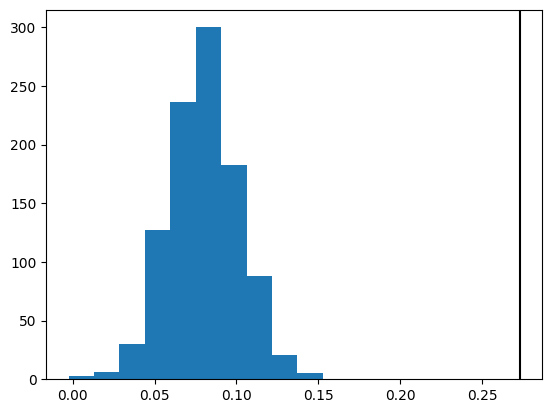

In [ ]:
# test if choice correlates with contrastLeft-contrastRight
#
# randomizing conditional on the block sequence

stat = np.mean(trials.choice * (trials.contrastLeft-trials.contrastRight))

N = 1000
null_dist = np.zeros(N-1)
for i in np.arange(N-1):
    nullContrastLeft, nullContrastRight, nullStim_side = generate_contrasts(trials.probabilityLeft)
    null_dist[i] = np.mean(trials.choice * (nullContrastLeft- nullContrastRight))

print('p=%.3f'%((1+np.sum(null_dist>=stat))/N))
plt.hist(null_dist)
plt.axvline(stat, color='k');

EXERCISE 1: repeat this analysis but not test if reaction time (stored in trials.delay) correlates with signed contrast



p=0.591


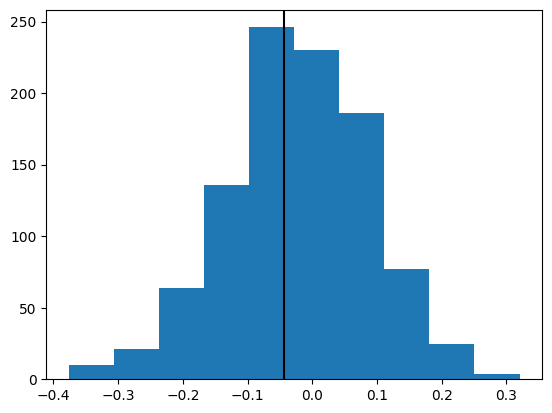

In [ ]:
# Should look something like this...

EXCERCISE 2: now do it again, but asking if reaction time correlates with the absolute contrast (trials.contrastLeft + trials.contrastRight)

HINT: if you get p=1.000, you need to change something. what?


p=0.001


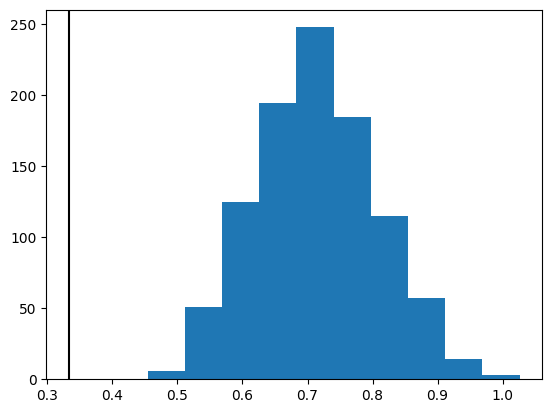

In [ ]:
# Should look something like this...

Now let's ask if the choice the mice make on zero contrast trials correlates with the probability of a left stimulus (i.e. the block) on that trial

QUESTION: what does this tell us? why is it valid?

QUESTION: if you run the test multiple times and sometimes get a p-value below 0.05 and sometimes above, what should you do?




p=0.046


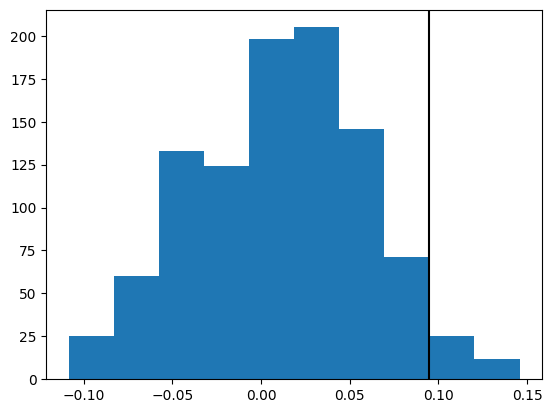

In [ ]:
zero_contrast_trials = (trials.contrastLeft==0) & (trials.contrastRight==0)

stat = np.mean(trials.choice[zero_contrast_trials] * trials.probabilityLeft[zero_contrast_trials])

N=1000
null_dist = np.zeros(N-1)
for i in np.arange(N-1):
    nullProbabilityLeft = generate_probabilities(n_trials)
    null_dist[i] = np.mean(trials.choice[zero_contrast_trials] * nullProbabilityLeft[zero_contrast_trials])

print('p=%.3f'%((1+np.sum(null_dist>=stat))/N))
plt.hist(null_dist)
plt.axvline(stat, color='k')

EXERCISE 4: do it again for all trials (not just zero contrast). what does that tell you?
